In [1]:
from variational_autoencoder import VariationalAutoEncoder
from verification_net import VerificationNet
from model_trainer import ModelTrainer
from stacked_mnist import StackedMNIST, DataMode

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps")
torch.mps.set_per_process_memory_fraction(0.)

trainer_file = Path("trainers/vae-basic.pkl")
model_file = Path("models/vae-basic")

In [3]:
class VariationalAutoEncoderTrainer(ModelTrainer):
    def __init__(
            self, 
            model, 
            loss, 
            optimizer,
            device = torch.device("mps"),
            file_name: str | Path = model_file, 
            force_learn: bool = False
        ) -> None:
        super().__init__(model, loss, optimizer, device, file_name, force_learn)

    def get_output_from_batch(self, batch):
        x, _, _ = batch
        x = x.to(self.device)
        (mu, log_var), x_hat = self.model(x)
        return (x_hat, x), (mu, log_var)

In [4]:
latent_space_size = 64

In [5]:
VAE = VariationalAutoEncoder(latent_space_size=latent_space_size)

In [6]:
def loss(X, params):
    x_hat, x = X
    mu, log_var = params
    BCE = F.binary_cross_entropy(x_hat, x, reduction='mean')
    KLD = torch.mean(- 0.5 * torch.mean(1 + log_var - mu.pow(2) - torch.exp(log_var), axis=1))

    return BCE + .02 * KLD

In [7]:
opt = optim.Adam(VAE.parameters(), lr=1e-6)

In [8]:
Trainer = VariationalAutoEncoderTrainer(
        model=VAE, 
        loss=loss, 
        optimizer=opt, 
        file_name=model_file,
        force_learn=False
    )

Could not read weights for verification_net from file. Must retrain...


In [9]:
Trainer = Trainer.load_trainer(trainer_file=trainer_file)

In [10]:
mode = DataMode.MONO | DataMode.BINARY

In [11]:
trainset = StackedMNIST(train=True, mode=mode)
testset = StackedMNIST(train=False, mode=mode)

/Users/arthurtestard/envs/ntnu/deeplearning/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [12]:
batch_size = 1
data = DataLoader(trainset, shuffle=True, batch_size=batch_size)
x, _, labels = next(iter(data))

In [13]:
Trainer.force_relearn and Trainer.done_training

False

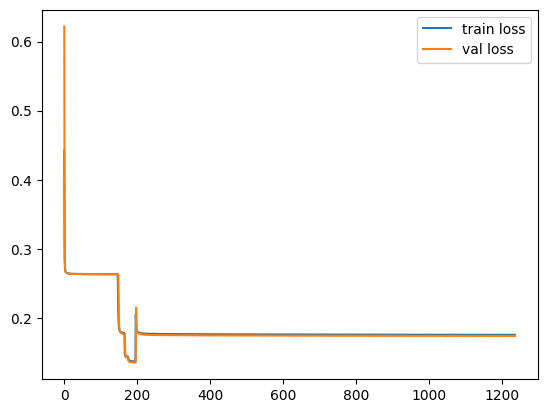

In [14]:
plt.plot(Trainer.losses, label="train loss")
plt.plot(Trainer.val_losses, label="val loss")
plt.legend()

In [15]:
train_loader = DataLoader(dataset=trainset, shuffle=True, batch_size=2048)
test_loader = DataLoader(dataset=testset, shuffle=True, batch_size=2048)

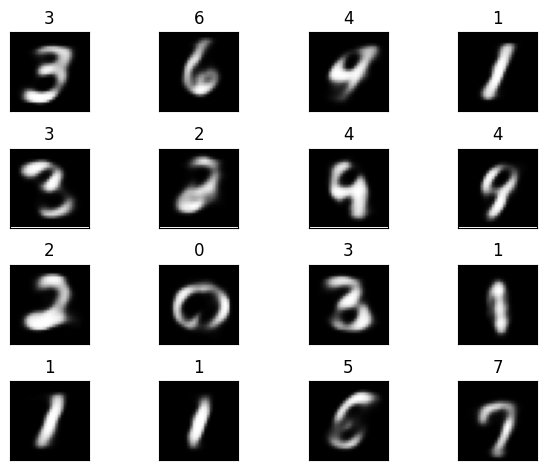

In [16]:
Trainer.print_reconstructed_img(trainset, batch_size=16)

In [17]:
VerifNet = VerificationNet(force_learn=False, file_name='models/verification_model_torch_ok_copy')

In [18]:
Trainer.print_class_coverage_and_predictability(VerifNet, dataset=trainset, batch_size=10_000)

Coverage: 100.00%
Predictability: 93.24%
Accuracy: 71.00%


In [19]:
Trainer.print_class_coverage_and_predictability(VerifNet, testset, batch_size=10_000)

Coverage: 100.00%
Predictability: 93.59%
Accuracy: 71.84%
